In [1]:
!rm -rf ActuarialThesis
!git clone https://github.com/aderdouri/ActuarialThesis.git
%ls -ltr ActuarialThesis

Cloning into 'ActuarialThesis'...
remote: Enumerating objects: 857, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 857 (delta 66), reused 98 (delta 36), pack-reused 717
Receiving objects: 100% (857/857), 123.09 MiB | 38.37 MiB/s, done.
Resolving deltas: 100% (356/356), done.
total 96
drwxr-xr-x 2 root root  4096 Oct 25 13:47 AllstateClaimPredictionChallenge/
drwxr-xr-x 2 root root  4096 Oct 25 13:47 AllstateClaimsSeverity/
drwxr-xr-x 2 root root  4096 Oct 25 13:47 Data/
drwxr-xr-x 2 root root  4096 Oct 25 13:47 EMTboost/
drwxr-xr-x 2 root root  4096 Oct 25 13:47 FrenchMotorThirdPartyLiabilityClaims/
drwxr-xr-x 2 root root  4096 Oct 25 13:47 Models/
drwxr-xr-x 2 root root  4096 Oct 25 13:47 Plots/
drwxr-xr-x 2 root root  4096 Oct 25 13:47 Notebooks/
drwxr-xr-x 2 root root  4096 Oct 25 13:47 src/
-rw-r--r-- 1 root root    54 Oct 25 13:47 README.md
-rw-r--r-- 1 root root 19545 Oct 25 13:47 myXGBoostRegressor.ipynb
-rw

In [2]:
!mkdir ActuarialThesis/plots_clf
!ls -ltr ActuarialThesis/plots_clf

total 0


In [3]:
# Ajouter le répértoire src
import sys
sys.path.insert(0,'./ActuarialThesis/src/')

In [4]:
import installHelper

In [5]:
print(list(dir(installHelper)))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'installALL', 'subprocess', 'sys']


## Installer les packages nécéssaires

In [6]:
installHelper.installALL()

In [7]:
# On doit trouver tous les packages mentionés dans le grep
!pip list -v | grep -e catboost -e 'imbalanced-learn' -e 'optuna' -e 'catboost' -e 'lime' -e 'shap' -e seaborn

catboost                         1.2.2                 /usr/local/lib/python3.10/dist-packages pip
imbalanced-learn                 0.10.1                /usr/local/lib/python3.10/dist-packages pip
lime                             0.2.0.1               /usr/local/lib/python3.10/dist-packages pip
optuna                           3.4.0                 /usr/local/lib/python3.10/dist-packages pip
seaborn                          0.12.2                /usr/local/lib/python3.10/dist-packages pip
shap                             0.43.0                /usr/local/lib/python3.10/dist-packages pip
shapely                          2.0.2                 /usr/local/lib/python3.10/dist-packages pip


### Importer les packages nécéssaires

In [8]:
from helper import *

In [9]:
# Apply the default theme
sns.set_theme()

# Partir du dataset déja encodé.

In [10]:
!ls -ltr ActuarialThesis/Data

total 10152
-rw-r--r-- 1 root root  562212 Oct 25 13:47 BASEAUTO.csv
-rw-r--r-- 1 root root  201188 Oct 25 13:47 df_models.csv
-rw-r--r-- 1 root root 3263186 Oct 25 13:47 encodedBASEAUTO.csv
-rw-r--r-- 1 root root 3273326 Oct 25 13:47 encodedCategoricalBASEAUTO.csv
-rw-r--r-- 1 root root 2236112 Oct 25 13:47 encodedTDboostEMTDboost.csv
-rw-r--r-- 1 root root  846739 Oct 25 13:47 transformedBASEAUTO.csv


In [11]:
# Partir du dataset déja encodé.
df = pd.read_csv('ActuarialThesis/Data/encodedBASEAUTO.csv')
df.head()

,ACV,SEX,STATUT,AGECOND,K8000,RM,CAR,USAGE_Prive,USAGE_PriveTrajet,USAGE_Professionnel,...,SEGM_H,SEGM_M1,SEGM_M2,GARAGE_ClosCollectif,GARAGE_GarageAutre,GARAGE_IndividuelClos,CSP_CSP_50,CSP_CSP_60,CSP_CSP_AUTRE,CHARGE
0,1.134929,1,1,-0.457663,0,-0.094064,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1.134929,1,0,1.101165,0,-0.817279,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.134929,1,1,-1.813166,0,1.507343,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.134929,1,0,0.626739,0,-0.817279,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.134929,1,0,-1.203190,0,1.507343,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [12]:
# Separation de la variable target du dataset
Y = df['CHARGE']
X = df.drop('CHARGE', axis=1)

# Target variable mapping

In [13]:
# Ici nous allons considérer le problème comme un problème de classification
# Class 0 si la CHARGE==0 sinon Class 1.
y = Y.map(lambda val: 0 if val<=0 else 1)

In [14]:
y.unique()

array([0, 1])

# Modeling

## 3.1 Handling the imbalances

Nous disposons de plusieurs options pour traiter les données déséquilibrées : sous-échantillonnage, suréchantillonnage, SMOTE, TomekLinks, etc. Toutefois, pour évaluer l'effet d'une méthode, nous devons d'abord disposer d'une sorte de base d'estimation.

Nous allons donc commencer par entraîner un classificateur Random Forest simple sur les données existantes, de la manière dont nous les avons prétraitées. Ensuite, nous essaierons quelques algorithmes et verrons si notre modèle s'améliore.

In [18]:
# Splitting dataset to obtain train/validation/test sets: 60:20:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [19]:
import optuna
import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection
import sklearn.svm

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 10, 150),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 30, 90),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced'])
    }

    rf_clf = RandomForestClassifier(**params, random_state=42)
    score = sklearn.model_selection.cross_val_score(rf_clf,
                            X_train,
                            y_train,
                            n_jobs=-1,
                            cv=3)
    accuracy = score.mean()
    return accuracy

In [20]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2023-10-25 13:56:02,079] A new study created in memory with name: no-name-e9179368-2288-43cb-b684-0bedcf736143
[I 2023-10-25 13:56:04,618] Trial 0 finished with value: 0.5761473717643323 and parameters: {'n_estimators': 339, 'max_depth': 12, 'min_samples_split': 83, 'min_samples_leaf': 60, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5761473717643323.
[I 2023-10-25 13:56:06,076] Trial 1 finished with value: 0.5759885659838019 and parameters: {'n_estimators': 140, 'max_depth': 20, 'min_samples_split': 18, 'min_samples_leaf': 57, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5761473717643323.
[I 2023-10-25 13:56:07,766] Trial 2 finished with value: 0.5877401937430523 and parameters: {'n_estimators': 224, 'max_depth': 42, 'min_samples_split': 22, 'min_samples_leaf': 46, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.5877401937430523.
[I 2023-10-25 13:56:09,401] Trial 3 finished with value: 0.591869144036843 and parameters: {'n_estimators': 449, 'm

FrozenTrial(number=69, state=TrialState.COMPLETE, values=[0.6053676353819278], datetime_start=datetime.datetime(2023, 10, 25, 13, 59, 18, 372865), datetime_complete=datetime.datetime(2023, 10, 25, 13, 59, 21, 570714), params={'n_estimators': 876, 'max_depth': 33, 'min_samples_split': 65, 'min_samples_leaf': 32, 'class_weight': 'balanced'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=50, log=False, low=10, step=1), 'min_samples_split': IntDistribution(high=150, log=False, low=10, step=1), 'min_samples_leaf': IntDistribution(high=90, log=False, low=30, step=1), 'class_weight': CategoricalDistribution(choices=('balanced',))}, trial_id=69, value=None)


In [21]:
rf_clf_hp = study.best_params
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.6053676353819278
  Params: 
    n_estimators: 876
    max_depth: 33
    min_samples_split: 65
    min_samples_leaf: 32
    class_weight: balanced


In [22]:
optimized_rf_clf = RandomForestClassifier(**rf_clf_hp)
optimized_rf_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=33,
                       min_samples_leaf=32, min_samples_split=65,
                       n_estimators=876)

In [25]:
y_pred = optimized_rf_clf.predict(X_test)
print(classification_report(y_test, y_pred))
print('Accuracy (balanced): {:.5f}'.format(balanced_accuracy_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.96      0.58      0.73      1837
           1       0.22      0.83      0.35       263

    accuracy                           0.61      2100
   macro avg       0.59      0.70      0.54      2100
weighted avg       0.87      0.61      0.68      2100

Accuracy (balanced): 0.70487


In [27]:
fig = optuna.visualization.plot_param_importances(study)
fig.write_image("./ActuarialThesis/plots_clf/myRandomForestClassifierParamImportances.pdf")
fig.show()

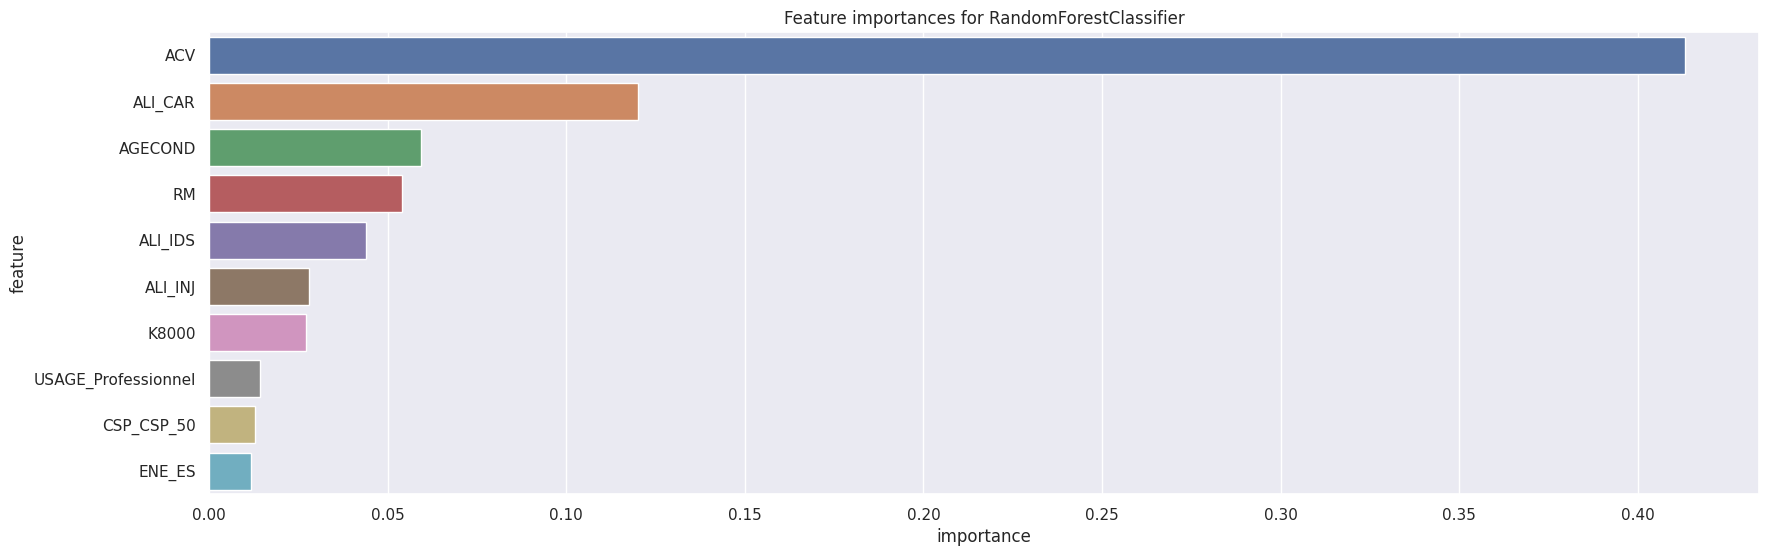

In [31]:
fig = plt.gcf()
fig.figure.set_size_inches(20, 6)
feature_importances = zip(X_train.columns, optimized_rf_clf.feature_importances_)
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
feature_importances = pd.DataFrame(feature_importances, columns=['feature', 'importance'])
plt.title('Feature importances for RandomForestClassifier')
sns.barplot(x='importance', y='feature', data=feature_importances[:10])
plt.savefig('./ActuarialThesis/plots_clf/myRandomForestClassifierFeatureImportances.pdf')

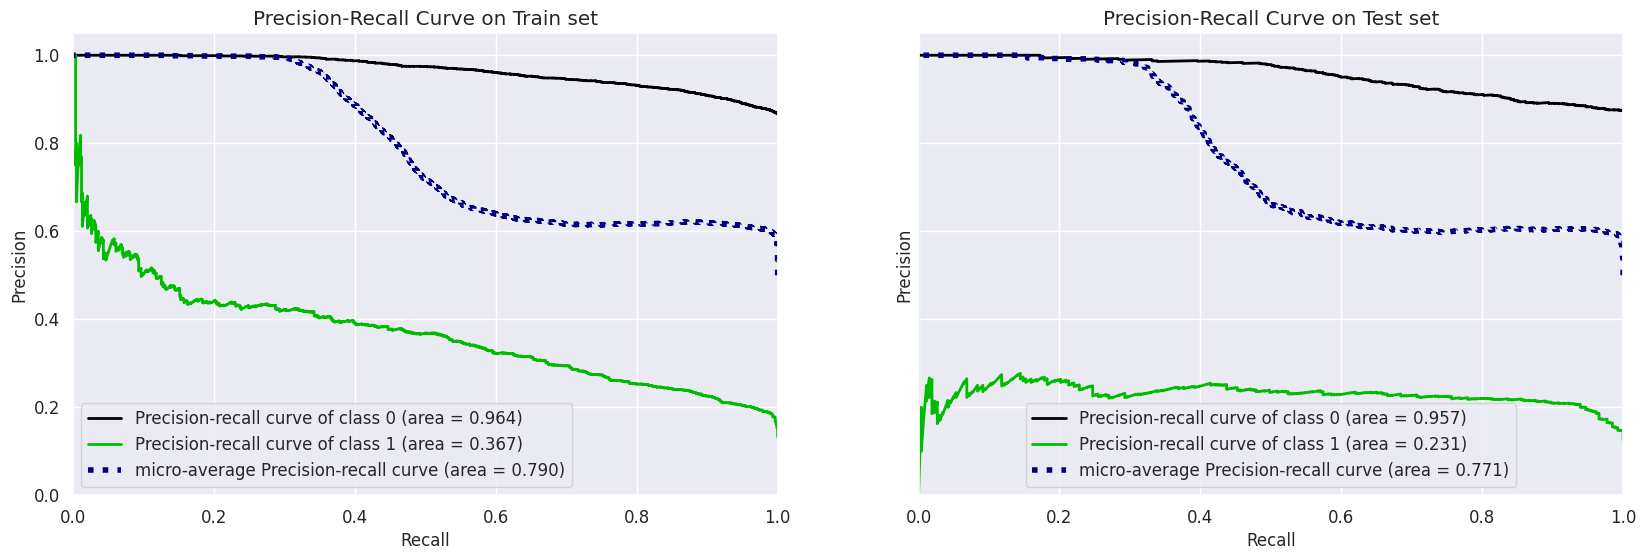

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18, 6))
y_probas = optimized_rf_clf.predict_proba(X_train)
skplt.metrics.plot_precision_recall(y_train, y_probas, ax = ax1, title = 'Precision-Recall Curve on Train set')

y_probas = optimized_rf_clf.predict_proba(X_test)
skplt.metrics.plot_precision_recall(y_test, y_probas, ax = ax2, title = 'Precision-Recall Curve on Test set')

fig.set_size_inches(20, 6)
fig.savefig('./ActuarialThesis/plots_clf/myRandomForestClassifierPrecisionRecallCurve.pdf', bbox_inches='tight')
plt.show();

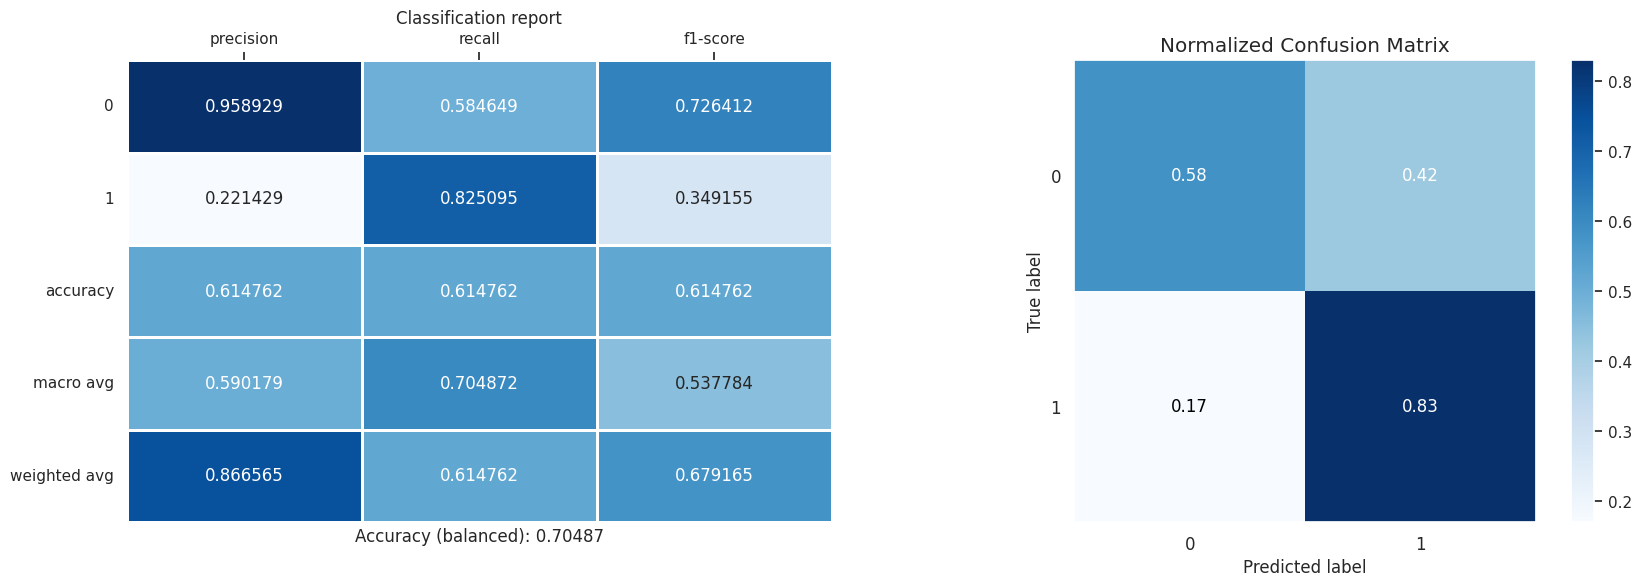

In [33]:
fig = plot_classification_report_confusion_matrix(optimized_rf_clf, X_test, y_test)
fig.set_size_inches(20, 6)
fig.savefig('./ActuarialThesis/plots_clf/myRandomForestClassifierConfusionMatrix.pdf', bbox_inches='tight')

In [34]:
experiment = RandomForestClassifier(
    n_estimators=876,
    max_depth=33,
    min_samples_split=65,
    min_samples_leaf =32,
    class_weight='balanced')

## Random Over Sampling

In [35]:
# Random Over Sampling
ros = RandomOverSampler(sampling_strategy=0.8)
ros_xtrain, ros_ytrain = ros.fit_resample(X_train.values, y_train.values)
experiment.fit(ros_xtrain, ros_ytrain)
y_pred = experiment.predict(X_val)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



In [37]:
y_pred = experiment.predict(X_val)
print(classification_report(y_val, y_pred))
print('Accuracy (balanced): {:.5f}'.format(balanced_accuracy_score(y_val, y_pred)))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



              precision    recall  f1-score   support

           0       0.93      0.57      0.71      1803
           1       0.22      0.74      0.34       296

    accuracy                           0.59      2099
   macro avg       0.58      0.66      0.52      2099
weighted avg       0.83      0.59      0.66      2099

Accuracy (balanced): 0.65670


In [38]:
# ADASYN
ada = ADASYN(sampling_strategy=0.8, n_neighbors=5)
ada_xtrain, ada_ytrain = ada.fit_resample(X_train.values, y_train.values)
experiment.fit(ada_xtrain, ada_ytrain)

RandomForestClassifier(class_weight='balanced', max_depth=33,
                       min_samples_leaf=32, min_samples_split=65,
                       n_estimators=876)

In [39]:
y_pred = experiment.predict(X_val)
print(classification_report(y_val, y_pred))
print('Accuracy (balanced): {:.5f}'.format(balanced_accuracy_score(y_val, y_pred)))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1803
           1       0.25      0.46      0.32       296

    accuracy                           0.72      2099
   macro avg       0.57      0.62      0.57      2099
weighted avg       0.81      0.72      0.76      2099

Accuracy (balanced): 0.61522


In [48]:
# SMOTETomek
smt = SMOTETomek(sampling_strategy=0.8)
smt_xtrain, smt_ytrain = smt.fit_resample(X_train.values, y_train.values)
experiment.fit(smt_xtrain, smt_ytrain)

RandomForestClassifier(class_weight='balanced', max_depth=33,
                       min_samples_leaf=32, min_samples_split=65,
                       n_estimators=876)

In [49]:
y_pred = experiment.predict(X_val)
print(classification_report(y_val, y_pred))
print('Accuracy (balanced): {:.5f}'.format(balanced_accuracy_score(y_val, y_pred)))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1803
           1       0.25      0.48      0.33       296

    accuracy                           0.73      2099
   macro avg       0.58      0.62      0.58      2099
weighted avg       0.81      0.73      0.76      2099

Accuracy (balanced): 0.62198


In [42]:
# TomekLinks
tl = TomekLinks()
tl_xtrain, tl_ytrain = tl.fit_resample(X_train.values, y_train.values)
experiment.fit(tl_xtrain, tl_ytrain)

RandomForestClassifier(class_weight='balanced', max_depth=33,
                       min_samples_leaf=32, min_samples_split=65,
                       n_estimators=876)

In [43]:
y_pred = experiment.predict(X_val)
print(classification_report(y_val, y_pred))
print('Accuracy (balanced): {:.5f}'.format(balanced_accuracy_score(y_val, y_pred)))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



              precision    recall  f1-score   support

           0       0.94      0.56      0.70      1803
           1       0.22      0.77      0.35       296

    accuracy                           0.59      2099
   macro avg       0.58      0.66      0.52      2099
weighted avg       0.84      0.59      0.65      2099

Accuracy (balanced): 0.66497


In [52]:
# RandomUnderSampler
rus = RandomUnderSampler()
rus_xtrain, rus_ytrain = rus.fit_resample(X_train.values, y_train.values)
experiment.fit(rus_xtrain, rus_ytrain)

RandomForestClassifier(class_weight='balanced', max_depth=33,
                       min_samples_leaf=32, min_samples_split=65,
                       n_estimators=876)

In [53]:
y_pred = experiment.predict(X_val)
print(classification_report(y_val, y_pred))
print('Accuracy (balanced): {:.5f}'.format(balanced_accuracy_score(y_val, y_pred)))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



              precision    recall  f1-score   support

           0       0.94      0.52      0.67      1803
           1       0.22      0.81      0.34       296

    accuracy                           0.56      2099
   macro avg       0.58      0.67      0.51      2099
weighted avg       0.84      0.56      0.62      2099

Accuracy (balanced): 0.66583


In [46]:
# NearMiss
nm = NearMiss(version=2, sampling_strategy=0.2, n_neighbors=5)
nm_xtrain, nm_ytrain = nm.fit_resample(X_train.values, y_train.values)
experiment.fit(nm_xtrain, nm_ytrain)

RandomForestClassifier(class_weight='balanced', max_depth=33,
                       min_samples_leaf=32, min_samples_split=65,
                       n_estimators=876)

In [47]:
y_pred = experiment.predict(X_val)
print(classification_report(y_val, y_pred))
print('Accuracy (balanced): {:.5f}'.format(balanced_accuracy_score(y_val, y_pred)))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



              precision    recall  f1-score   support

           0       0.92      0.58      0.71      1803
           1       0.21      0.67      0.32       296

    accuracy                           0.59      2099
   macro avg       0.56      0.63      0.51      2099
weighted avg       0.82      0.59      0.66      2099

Accuracy (balanced): 0.62650


In [219]:
df_initial = pd.DataFrame({'class_initial_data': y_train})
df_RandomOverSampler = pd.DataFrame({'class_RandomOverSampler': ros_ytrain})
df_ADASYN = pd.DataFrame({'class_ADASYN': ada_ytrain})
df_SMOTETomek = pd.DataFrame({'class_SMOTETomek': smt_ytrain})
df_TomekLinks = pd.DataFrame({'class_TomekLinks': tl_ytrain})
df_RandomUnderSampler = pd.DataFrame({'class_RandomUnderSampler': rus_ytrain})
df_NearMiss = pd.DataFrame({'class_NearMiss': nm_ytrain})

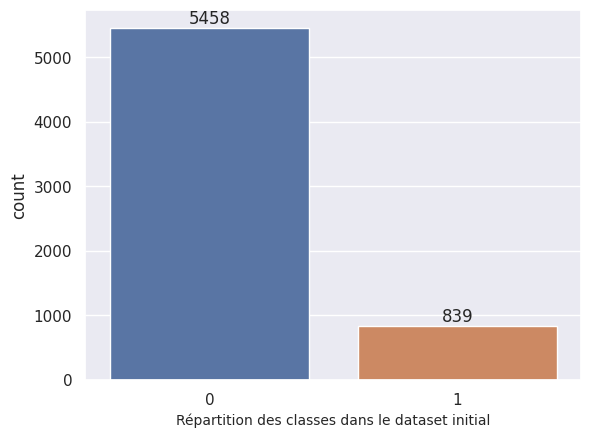

In [220]:
ax = sns.countplot(data=df_initial, x='class_initial_data')
ax.bar_label(ax.containers[0]);
ax.set_xlabel('Répartition des classes dans le dataset initial', fontsize=10)

fig = ax.get_figure()
fig.savefig('./ActuarialThesis/plots_clf/myInitialClassRepartition.pdf', bbox_inches='tight')

In [221]:
def plotClass(ax, df, colName, rowId, colId, title=''):
  _ax = sns.countplot(data=df, x=colName, ax=ax[rowId][colId])
  _ax.bar_label(_ax.containers[0])
  _ax.set_xlabel('Répartition des classes dans '+ title, fontsize=10)

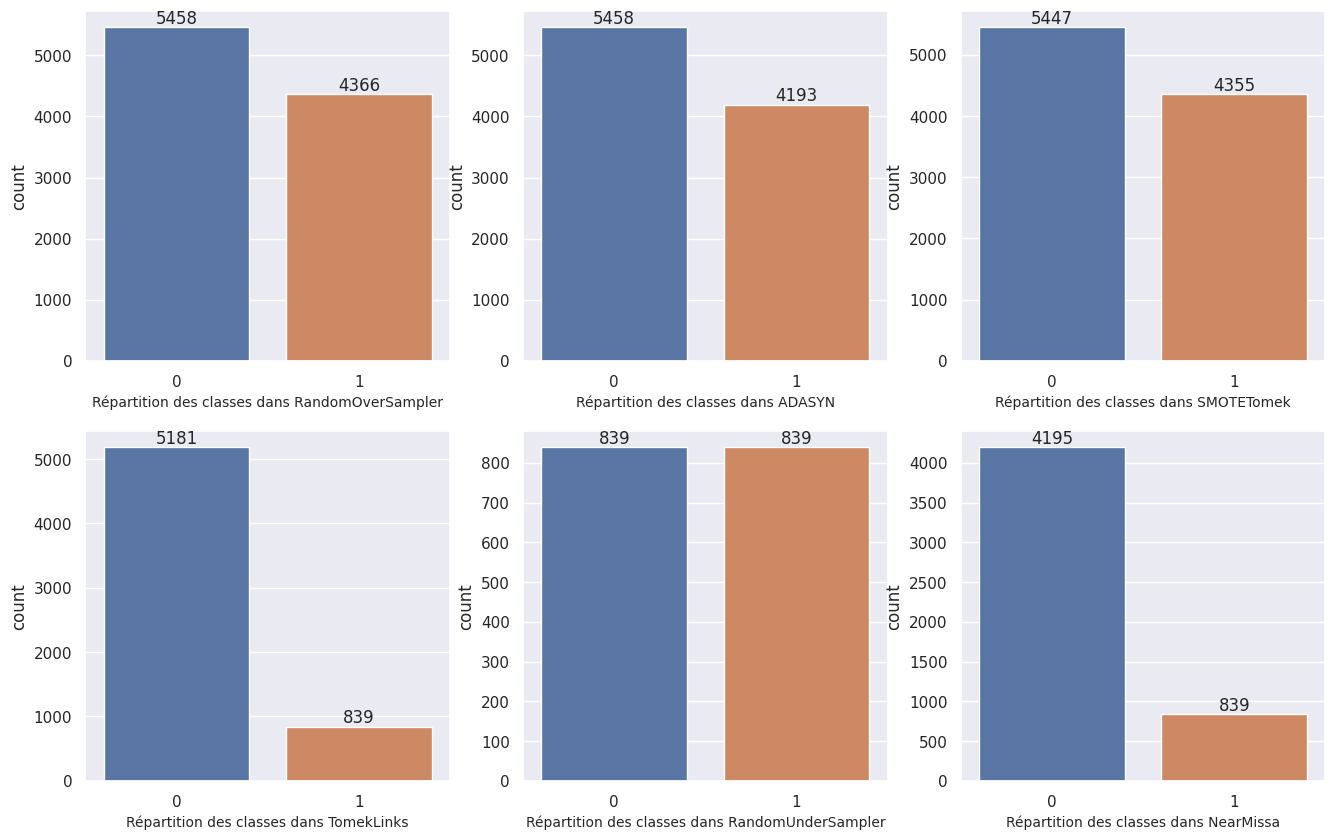

In [222]:
fig, ax = plt.subplots(2, 3, figsize=(16, 10))
#plotClass(ax, df_initial, 'class_initial_data', 0, 0)
plotClass(ax, df_RandomOverSampler, 'class_RandomOverSampler', 0, 0, 'RandomOverSampler')
plotClass(ax, df_ADASYN, 'class_ADASYN', 0, 1, 'ADASYN')
plotClass(ax, df_SMOTETomek, 'class_SMOTETomek', 0, 2, 'SMOTETomek')
plotClass(ax, df_TomekLinks, 'class_TomekLinks', 1, 0, 'TomekLinks')
plotClass(ax, df_RandomUnderSampler, 'class_RandomUnderSampler', 1, 1, 'RandomUnderSampler')
plotClass(ax, df_NearMiss, 'class_NearMiss', 1, 2, 'NearMissa')

#fig.set_size_inches(16, 16)
fig.savefig('./ActuarialThesis/plots_clf/mySamplingTransformation.pdf', bbox_inches='tight')


Ni la création de nouveaux échantillons synthétiques pour la classe mineure, ni l'élimination de la surabondance de la classe majeure ne semblent aider notre algorithme. Aucun des algorithmes testés ne s'est avéré suffisamment prometteur pour continuer à ajuster les paramètres.

À l'avenir, nous n'utiliserons plus aucun de ces algorithmes, mais uniquement notre ensemble de données d'entraînement prétraitées.



### LogisticRegression

Back to the basics we go.

In [83]:
def objective(trial):
  params = {
      'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
      'tol': trial.suggest_float('tol', 0.001, 0.1, log=True),
      'C': trial.suggest_float('C', 1.0, 10.0, log=True),
      'l1_ratio': trial.suggest_float('l1_ratio', 0.001, 1.0, log=True),
      'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
      'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
      'multi_class': trial.suggest_categorical('multi_class', ['auto']),
      'class_weight': trial.suggest_categorical('class_weight', ['balanced'])
  }
  lr_clf = LogisticRegression(**params, random_state=42)
  score = sklearn.model_selection.cross_val_score(lr_clf,
                          X_train,
                          y_train,
                          scoring='roc_auc',
                          n_jobs=-1,
                          verbose=10,
                          cv=5)
  accuracy = score.mean()
  return accuracy

In [84]:
%%time
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-10-25 16:16:45,223] A new study created in memory with name: no-name-89202e4f-7a69-4daf-9625-9cb09c4324ab
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[I 2023-10-25 16:16:47,124] Trial 0 finished with value: 0.7152810631858134 and parameters: {'penalty': 'l1', 'tol': 0.0018636792697375253, 'C': 2.2360778137355464, 'l1_ratio': 0.0012322460585845504, 'fit_intercept': True, 'solver': 'liblinear', 'multi_class': 'auto', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7152810631858134.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07979202270507812s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.

CPU times: user 5.41 s, sys: 661 ms, total: 6.07 s
Wall time: 22.5 s


In [85]:
lr_clf_hp = study.best_params
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.7183809583671067
  Params: 
    penalty: l1
    tol: 0.08261744059487562
    C: 1.0069299339799098
    l1_ratio: 0.17345395893982382
    fit_intercept: True
    solver: saga
    multi_class: auto
    class_weight: balanced


In [86]:
%%time
optimized_lr_clf = LogisticRegression(**lr_clf_hp)
optimized_lr_clf.fit(X_train, y_train)

CPU times: user 47.5 ms, sys: 2.8 ms, total: 50.3 ms
Wall time: 49.1 ms


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)



LogisticRegression(C=1.0069299339799098, class_weight='balanced',
                   l1_ratio=0.17345395893982382, penalty='l1', solver='saga',
                   tol=0.08261744059487562)

In [87]:
y_pred = optimized_lr_clf.predict(X_val)
print(classification_report(y_val, y_pred))
print('Accuracy (balanced): {:.5f}'.format(balanced_accuracy_score(y_val, y_pred)))

              precision    recall  f1-score   support

           0       0.93      0.62      0.75      1803
           1       0.24      0.72      0.36       296

    accuracy                           0.64      2099
   macro avg       0.59      0.67      0.55      2099
weighted avg       0.83      0.64      0.69      2099

Accuracy (balanced): 0.67208


In [97]:
fig = optuna.visualization.plot_param_importances(study)
fig.write_image("./ActuarialThesis/plots_clf/myLogisticRegressionClassifierParamImportances.pdf")
fig.show()

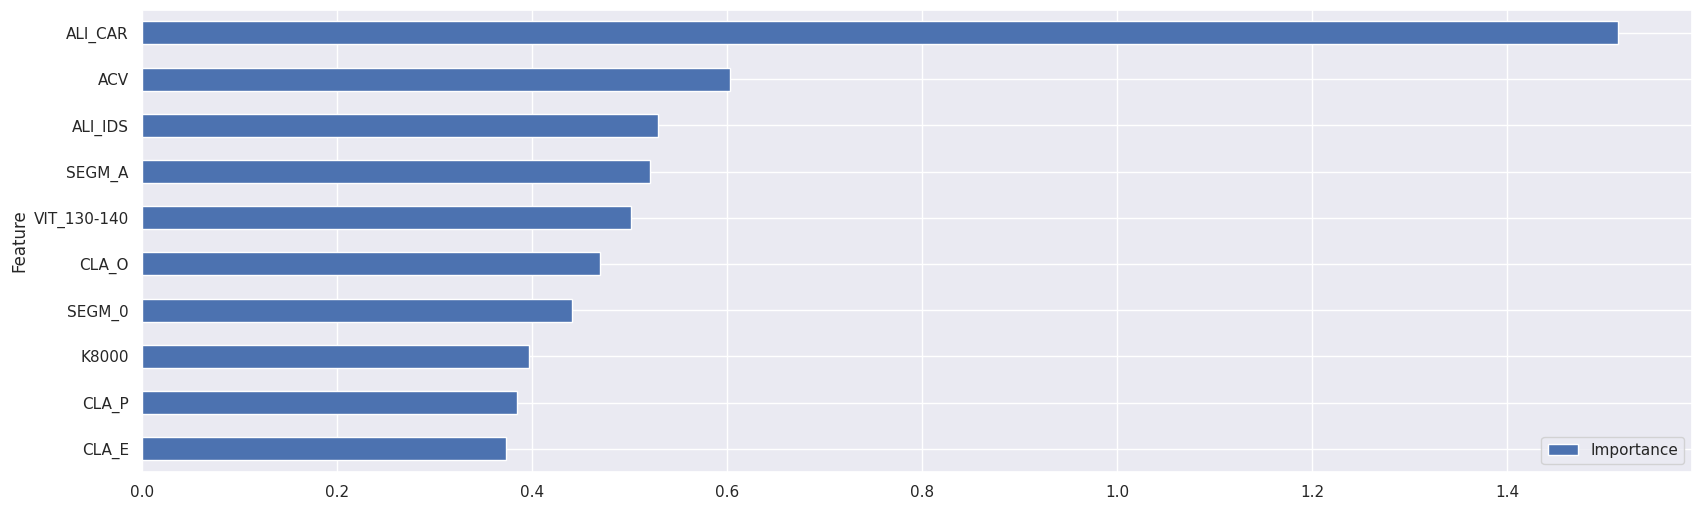

In [98]:
coefficients = optimized_lr_clf.coef_[0]
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importances = feature_importances.sort_values('Importance', ascending=True)
feature_importances.iloc[-10:].plot(x='Feature', y='Importance', kind='barh')
fig = plt.gcf()
fig.figure.set_size_inches(20, 6)
plt.savefig('./ActuarialThesis/plots_clf/myLogisticRegressionClassifierFeatureImportances.pdf')

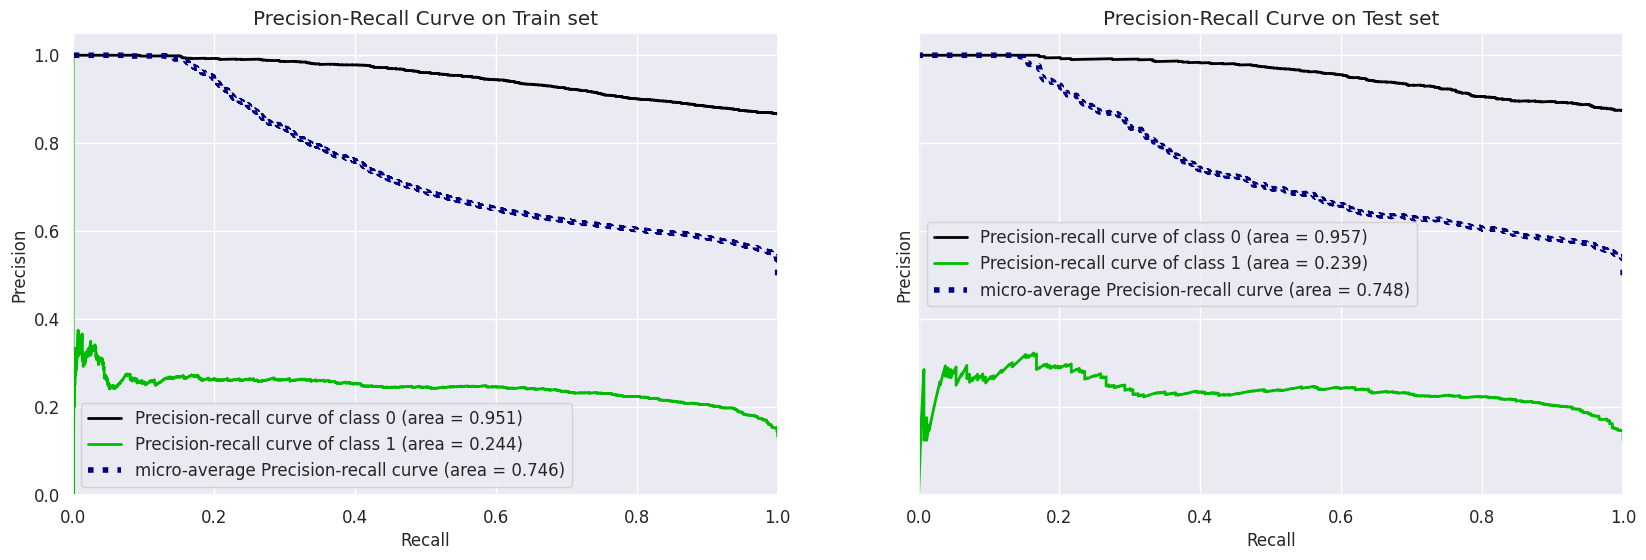

In [99]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18, 6))
y_probas = optimized_lr_clf.predict_proba(X_train)
skplt.metrics.plot_precision_recall(y_train, y_probas, ax = ax1, title = 'Precision-Recall Curve on Train set')

y_probas = optimized_lr_clf.predict_proba(X_test)
skplt.metrics.plot_precision_recall(y_test, y_probas, ax = ax2, title = 'Precision-Recall Curve on Test set')

fig.set_size_inches(20, 6)
fig.savefig('./ActuarialThesis/plots_clf/myLogisticRegressionClassifierPrecisionRecallCurve.pdf', bbox_inches='tight')
plt.show();

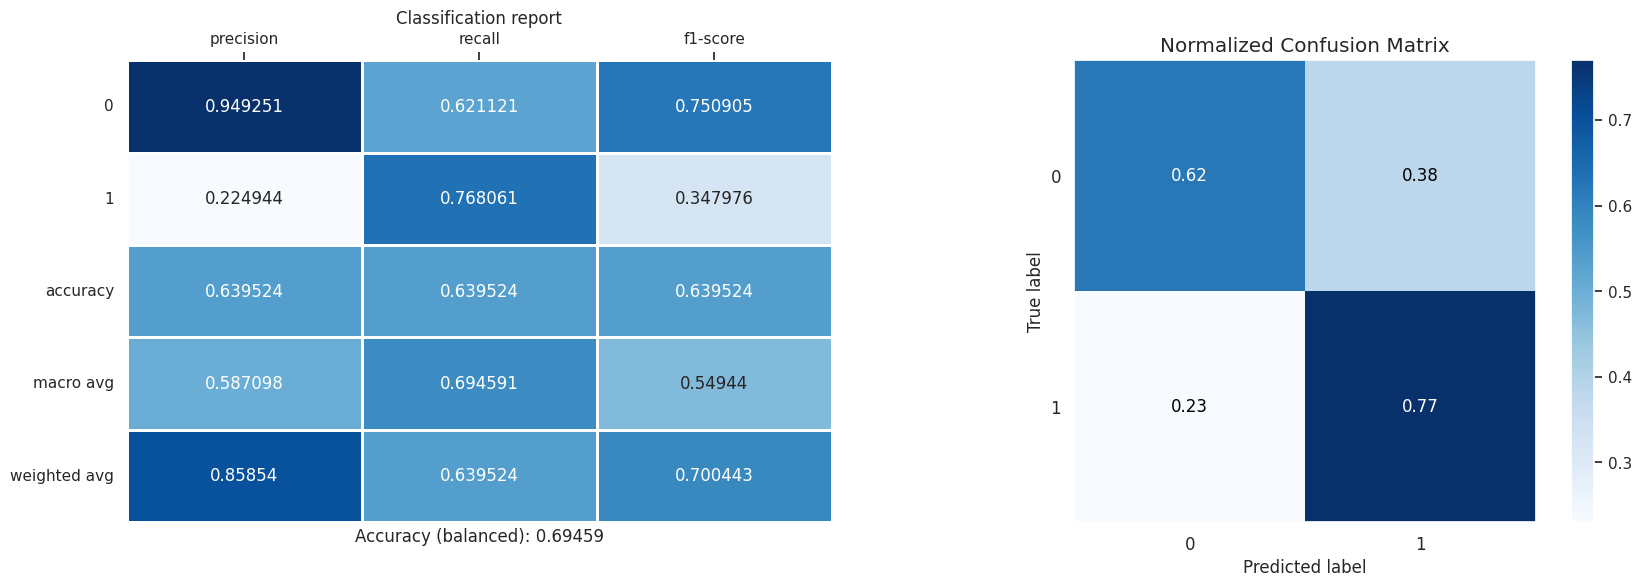

In [100]:
fig = plot_classification_report_confusion_matrix(optimized_lr_clf, X_test, y_test)
fig.set_size_inches(20, 6)
fig.savefig('./ActuarialThesis/plots_clf/myLogisticRegressionClassifierConfusionMatrix.pdf', bbox_inches='tight')

#### Ensemble

Now let's blend our models and tune the weights of each for the best predictions. There are 2 methdos to do that:
* Create an array of valid weights (that sum up to 1) and iterate through each combination for the models to see what produces the best result
* Train a model to take outputs of models in ensemble and let it find out the weights on its own.

Now, because my metric is PR AUC, I actually need predicted probabilities to calculate it. Because tuning weight manually will not give me that and using different metric for tuning is inherently flawed idea, I will go with the second option and tune simple Logistic Regression. That will allow me obtain the same metric for ensemble as I used for separate models.

In [ ]:
# Creating the blend of prediction on training set
y_predt_rf = pd.Series(optimized_rf_clf.predict(X_train), name='rf')
y_predt_lr = pd.Series(optimized_lr_clf.predict(X_train), name='lr')
X_train_blend = pd.concat([y_predt_rf, y_predt_lr], axis=1)

# Creating the blend of prediction on validation set
y_predv_rf = pd.Series(optimized_rf_clf.predict(X_val), name='rf')
y_predv_lr = pd.Series(optimized_lr_clf.predict(X_val), name='lr')
X_val_blend = pd.concat([y_predv_rf, y_predv_lr], axis=1)

In [ ]:
X_train_blend.head()

,rf,lr
0,0,0
1,1,1
2,1,1
3,0,0
4,1,1


In [ ]:
# Tuning weights
ensemble = LogisticRegression(class_weight='balanced')
ensemble.fit(X_train_blend, y_train)

LogisticRegression(class_weight='balanced')

In [ ]:
y_pred = ensemble.predict(X_val_blend)
print(classification_report(y_val, y_pred))
print('Accuracy (balanced): {:.5f}'.format(balanced_accuracy_score(y_val, y_pred)))

              precision    recall  f1-score   support

           0       0.94      0.57      0.71      1803
           1       0.23      0.77      0.35       296

    accuracy                           0.60      2099
   macro avg       0.58      0.67      0.53      2099
weighted avg       0.84      0.60      0.66      2099

Accuracy (balanced): 0.66797


Text(0.5, 0, 'Relative Feature Importance')

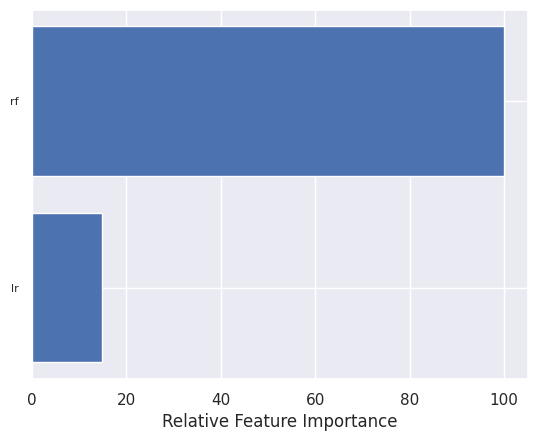

In [ ]:
feature_importance = abs(ensemble.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train_blend.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

### Summary

#### Test data processing

In [ ]:
# Let's consider a test set
_, X_test, _, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

#### Evaluating models

Now we can check each model's performance on the test set and their combined performance as an ensemble.

In [ ]:
y_predtst_rf = pd.Series(optimized_rf_clf.predict(X_test), name='rf')
y_predtst_lr = pd.Series(optimized_lr_clf.predict(X_test), name='lr')
X_test_blend = pd.concat([y_predtst_rf, y_predtst_lr], axis=1)

In [ ]:
X_test_blend.shape, y_test.shape

((2100, 2), (2100,))

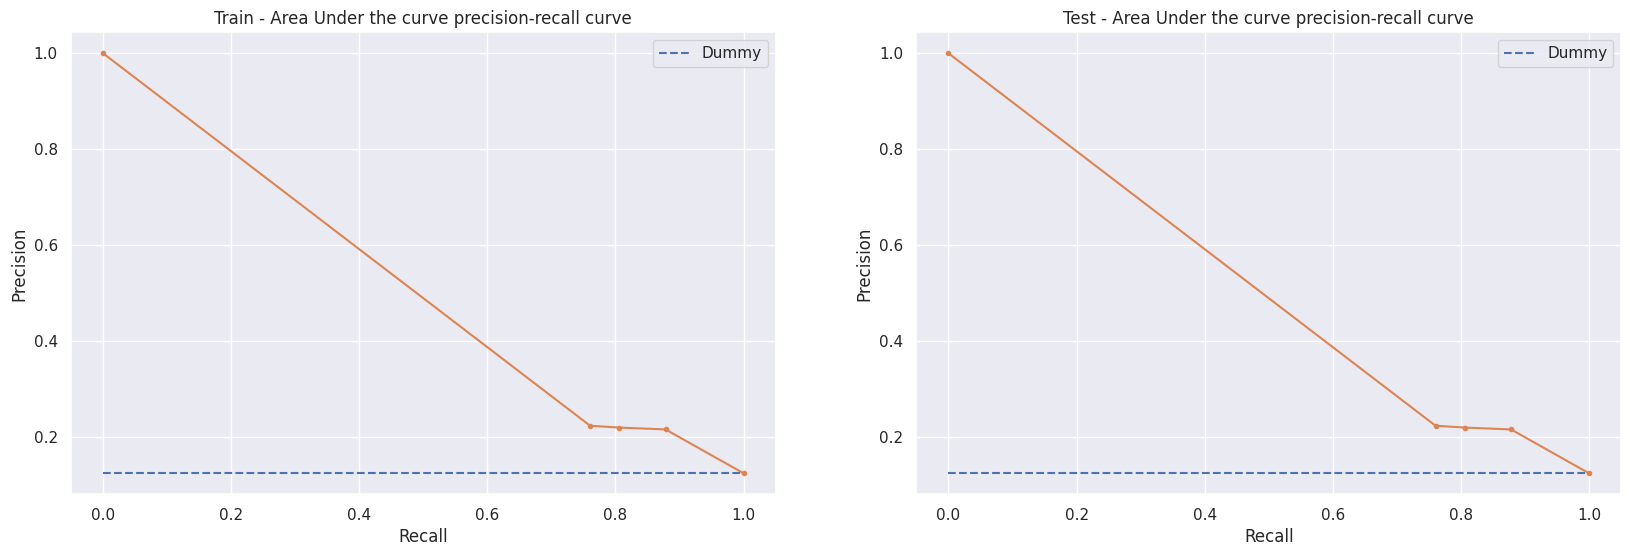

In [ ]:
fig = plot_pr_auc(ensemble, X_test_blend, y_test, X_test_blend, y_test, OurModelName= '_', title='')
fig.set_size_inches(20, 6)
fig.savefig('./ActuarialThesis/plots_clf/myLogisticRegressionAUCPR.pdf', bbox_inches='tight')
plt.show();

In [ ]:
y_pred = ensemble.predict(X_test_blend)
print(classification_report(y_test, y_pred))
print('Accuracy (balanced): {:.5f}'.format(balanced_accuracy_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.96      0.59      0.73      1837
           1       0.22      0.81      0.35       263

    accuracy                           0.62      2100
   macro avg       0.59      0.70      0.54      2100
weighted avg       0.86      0.62      0.68      2100

Accuracy (balanced): 0.69890
